In [1]:
import pandas as pd
import numpy as np
import re
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report,\
precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize

import pymorphy2

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-6-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 19 s, sys: 560 ms, total: 19.6 s
Wall time: 19.6 s


In [8]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 8s, sys: 76 ms, total: 2min 9s
Wall time: 2min 9s


In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
common_dictionary[10]

'ватутин'

In [11]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 57.1 s, sys: 528 ms, total: 57.7 s
Wall time: 21.9 s


In [12]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [13]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(8, 0.09726855),
 (15, 0.16400155),
 (16, 0.1026947),
 (22, 0.16323009),
 (24, 0.4515889)]

In [14]:
x = lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: смерть космос рейс расследование лечение офицер умереть
topic_1: тело белый осложнение номинация мешок скончаться североамериканский
topic_2: банк сотрудник россия право проверка санкция российский
topic_3: военный ракета млрд земля источник данные млн
topic_4: nn закон конкурс принять реформа русский памятник
topic_5: выяснить кровь украинский обнаружить всё катастрофа треть
topic_6: экономика ребёнок рак управление родитель писать ссылка
topic_7: сша американский россия российский nn журнал северный
topic_8: газ исследование путин агентство эксперимент чиновник владимир
topic_9: турция болезнь агентство сон медик ирак литва
topic_10: парк мэй грунт сооружение концерн негативно партнёрство
topic_11: украина украинский киев донбасс газ украинец антонов
topic_12: ребёнок женщина произойти товар восток пострадать инцидент
topic_13: статья снижение погибнуть рф nn россия тыс
topic_14: университет мозг автор опубликовать мужчина возраст звезда
topic_15: рост всё научный новый наук

In [15]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [16]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.000000,0.130083,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.083636,0.0,0.0,0.000000,0.000000,0.000000
1,4896,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.689602,0.000000,0.0,0.0,0.000000,0.000000,0.286171
2,4897,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.097266,...,0.164011,0.102722,0.0,0.000000,0.000000,0.0,0.0,0.163205,0.000000,0.451580
3,4898,0.0,0.0,0.0,0.135234,0.000000,0.252346,0.000000,0.195322,0.000000,...,0.241494,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.144548
4,4899,0.0,0.0,0.0,0.000000,0.000000,0.077084,0.236095,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.187676,0.0,0.0,0.000000,0.474376,0.000000


In [17]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [18]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [19]:
doc_dict[293622]

array([0.        , 0.        , 0.04101559, 0.02670158, 0.16203658,
       0.        , 0.        , 0.16824274, 0.13593069, 0.        ,
       0.        , 0.        , 0.        , 0.13295908, 0.29146561,
       0.        , 0.        , 0.        , 0.        , 0.03010131,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [20]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [21]:
get_user_embedding(user_articles_list)

array([0.00966341, 0.01428059, 0.06401366, 0.08834267, 0.10266973,
       0.        , 0.02367991, 0.07160712, 0.15205163, 0.        ,
       0.        , 0.        , 0.01978307, 0.02147973, 0.        ,
       0.09779196, 0.03129414, 0.        , 0.08322962, 0.05102954,
       0.        , 0.        , 0.06463302, 0.09061072, 0.        ])

In [22]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.067027,0.027348,0.072018,0.042515,0.076737,0.045628,0.114797,...,0.017728,0.013413,0.0,0.057379,0.079639,0.0,0.000000,0.014706,0.092113,0.0
1,u108690,0.002056,0.002079,0.116222,0.051841,0.012747,0.011433,0.012071,0.086601,0.089066,...,0.134913,0.044955,0.0,0.108157,0.031763,0.0,0.003344,0.008082,0.067884,0.0
2,u108339,0.002621,0.014820,0.091638,0.082489,0.052147,0.012930,0.016049,0.041029,0.058356,...,0.057754,0.053775,0.0,0.125673,0.100569,0.0,0.003178,0.047016,0.033880,0.0


In [23]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [24]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.067027,0.027348,0.072018,0.042515,0.076737,0.045628,0.114797,...,0.013413,0.0,0.057379,0.079639,0.0,0.000000,0.014706,0.092113,0.0,0
1,u108690,0.002056,0.002079,0.116222,0.051841,0.012747,0.011433,0.012071,0.086601,0.089066,...,0.044955,0.0,0.108157,0.031763,0.0,0.003344,0.008082,0.067884,0.0,1
2,u108339,0.002621,0.014820,0.091638,0.082489,0.052147,0.012930,0.016049,0.041029,0.058356,...,0.053775,0.0,0.125673,0.100569,0.0,0.003178,0.047016,0.033880,0.0,1


In [25]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [26]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [27]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.13894306, 0.02583079, 0.34300051, 0.15817403, 0.04592158,
       0.08214068, 0.13016069, 0.17797911, 0.06518896, 0.07164617])

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall + 10e-8)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
f_score_mean = fscore[ix]
precision_mean = precision[ix]
recall_mean = recall[ix]

Best Threshold=0.241027, F-Score=0.645, Precision=0.550, Recall=0.780


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1599  156]
 [  55  190]]


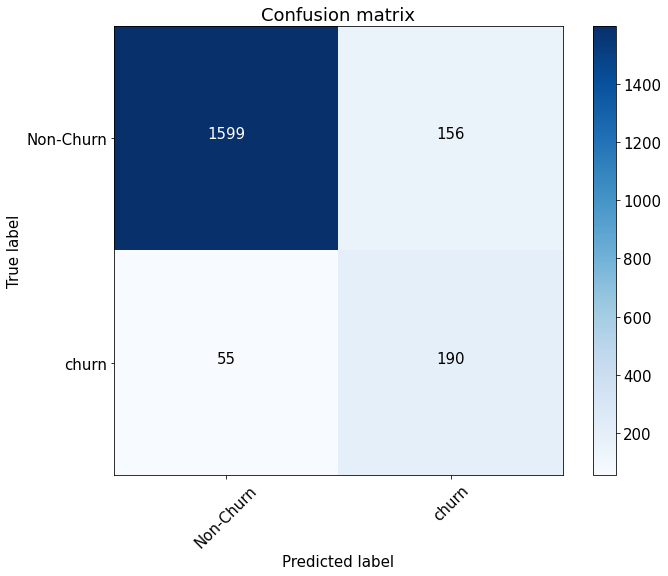

In [30]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [31]:
roc_auc_score_mean = roc_auc_score(y_test, preds)
roc_auc_score_mean

0.9360358160358161

1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [32]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

Best Threshold=0.275342, F-Score=0.755, Precision=0.680, Recall=0.849
Confusion matrix, without normalization
[[1657   98]
 [  38  207]]


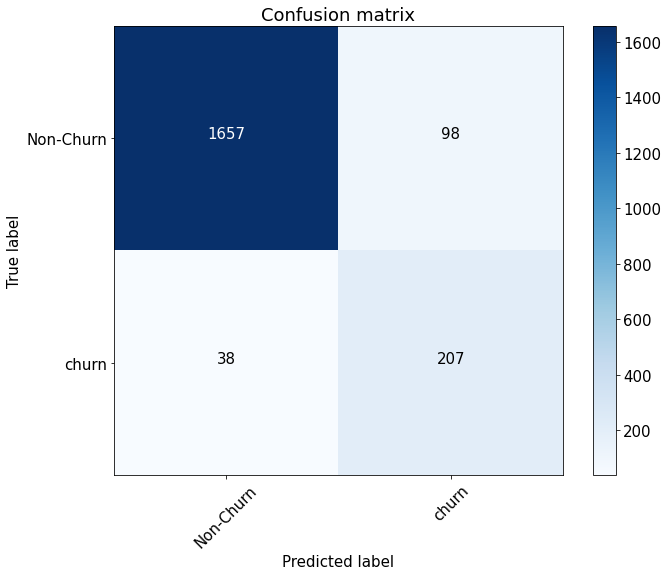

0.970600616314902

In [33]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]


X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall + 10e-8)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
f_score_median = fscore[ix]
precision_median = precision[ix]
recall_median = recall[ix]

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

roc_auc_score_median = roc_auc_score(y_test, preds)
roc_auc_score_median

2. Повторить п.1, но используя уже не медиану, а max

In [34]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

Best Threshold=0.418234, F-Score=0.801, Precision=0.823, Recall=0.780
Confusion matrix, without normalization
[[1714   41]
 [  55  190]]


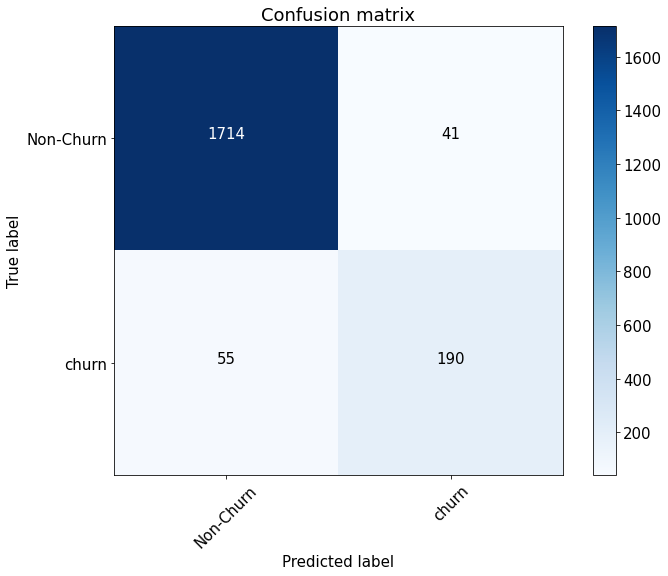

0.9783499040641896

In [35]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]


X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall + 10e-8)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
f_score_max = fscore[ix]
precision_max = precision[ix]
recall_max = recall[ix]

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

roc_auc_score_max = roc_auc_score(y_test, preds)
roc_auc_score_max

3. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.0, повторить пункт 1, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

4. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [36]:
df = pd.DataFrame({'user_embeddings': ['mean', 'median', 'max'],
                   'roc_auc': [roc_auc_score_mean, roc_auc_score_median, roc_auc_score_max],
                  'precision': [precision_mean, precision_median, precision_max],
                  'recall': [recall_mean, recall_median, recall_max],
                  'f_score': [f_score_mean, f_score_median, f_score_max]})

df.set_index('user_embeddings', drop=True, inplace=True)

df

,roc_auc,precision,recall,f_score
user_embeddings,,,,
mean,0.936036,0.550432,0.779592,0.645270
median,0.970601,0.679739,0.848980,0.754991
max,0.978350,0.823276,0.779592,0.800839


5. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Метрики для median и max получились наиболее высокими и чередуются с каждым перезапуском.
Думаю что это произошло потому, что max выбрал наиболее характерные для пользователя темы - те, которые он, возможно, читает не очень часто (поэтому median в теории может оказаться чуть хуже), но которые дают более точное представление о его поведении. mean, возможно, оказался самым плохим вариантом из-за "выбросов" - случайно или просто прочитанных в качестве исключения, не соответствующих основным темам, интересующим пользователя новостей.